In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ENGLISH_COLUMNS = [
    "category",
    "accident_type",
    "year",
    "month",
    "value",
    # "important are the first 5 columns"
    # ...
]

file_path = "./data/monatszahlen2209_verkehrsunfaelle.csv"
data = pd.read_csv(file_path, usecols = range(5))
data.columns = ENGLISH_COLUMNS

# translating values to english to enable interpretation
category_map = {k: v for k, v in zip(("Alkoholunfälle", "Fluchtunfälle", "Verkehrsunfälle"), ("alcohol", "escape", "traffic"))}
acident_type_map = {k: v for k, v in zip(("insgesamt", "Verletzte und Getötete", "mit Personenschäden"), ("total", "injured_or_killed", "personal_injury"))}
data["category"] = data["category"].map(category_map)
data["accident_type"] = data["accident_type"].map(acident_type_map)

# drop `nan`s values
data.drop(index = data[data.year == 2022].index, inplace = True) # .isnull().sum() == 0
# remove rows that contain the total of the year
data.drop(index = data[data.month == "Summe"].index, inplace = True)

# convert year and month to int
data["year"] = data.year.astype(int)
data["month"] = data.month.astype(int).apply(lambda yearmonth: yearmonth % 100)
data["date"] = pd.to_datetime(data[["year", "month"]].assign(day=1))
# df.set_index(["date", "category"], inplace = True)

data.to_csv("./data/en_traffic.csv", index = False)

df = data.copy()

# df = df[df.accident_type == "total"][["date", "accident_type", "category", "value"]].copy()

In [2]:
df[df.accident_type == "total"].groupby("category").value.describe()

# it is important to note how different are the scales: while `alcohol`
# average and standard deviation are about 43 and 18, `traffic`'s are 
# 3537 and 479. This means that, when predicting `total`, `traffic` will
# have a much higher weight than `alcohol`.

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
alcohol,264.0,43.215909,18.066701,10.0,30.0,40.0,53.00,107.0
escape,264.0,876.875000,136.937288,411.0,791.0,873.5,966.25,1187.0
traffic,264.0,3520.412879,489.594991,2153.0,3196.0,3464.5,3890.50,4763.0


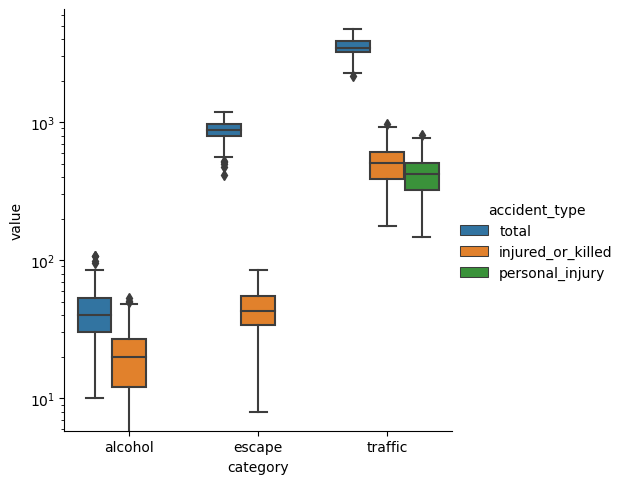

In [3]:
# plot `value` distribution in relation to `category` and `acident_type`
sns.catplot(x="category", y="value", hue="accident_type", kind="box", data=df)
plt.yscale("log")

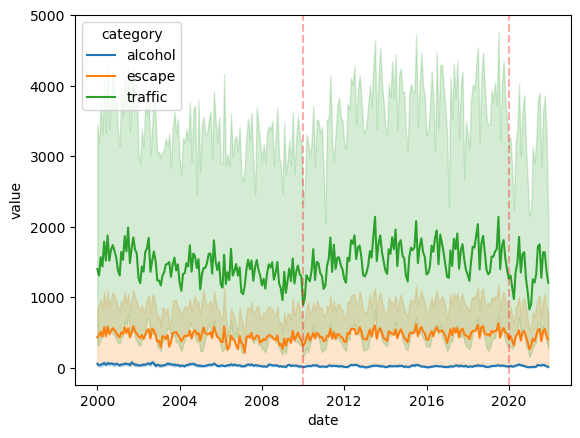

In [4]:
# plot `value` over `time` for each `category`
sns.lineplot(data = df, x = "date", y = "value", hue = "category")
plt.axvline(pd.to_datetime("2020-01-01"), color = "red", linestyle = "--", label = "start of pandemic", alpha = .33)

# it seems that the `traffic` category has a different pattern before ~2012
# moreover, from then on it seems like `traffic` average and variance increased
idxmin = df[(df.date.dt.year < 2012) & (df.category == "traffic")].value.argmin()
datemin = df.loc[idxmin, "date"]
plt.axvline(datemin, color = "red", linestyle = "--", label = "change of pattern", alpha = .33)

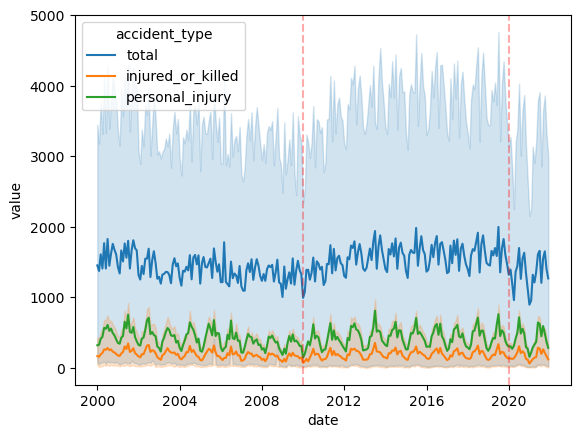

In [5]:
# plot `value` over `time` for each `category`
sns.lineplot(data = df, x = "date", y = "value", hue = "accident_type")
plt.axvline(pd.to_datetime("2020-01-01"), color = "red", linestyle = "--", label = "start of pandemic", alpha = .33)

# it seems that the `traffic` category has a different pattern before ~2012
# moreover, from then on it seems like `traffic` average and variance increased
idxmin = df[(df.date.dt.year < 2012) & (df.category == "traffic")].value.argmin()
datemin = df.loc[idxmin, "date"]
plt.axvline(datemin, color = "red", linestyle = "--", label = "change of pattern", alpha = .33)

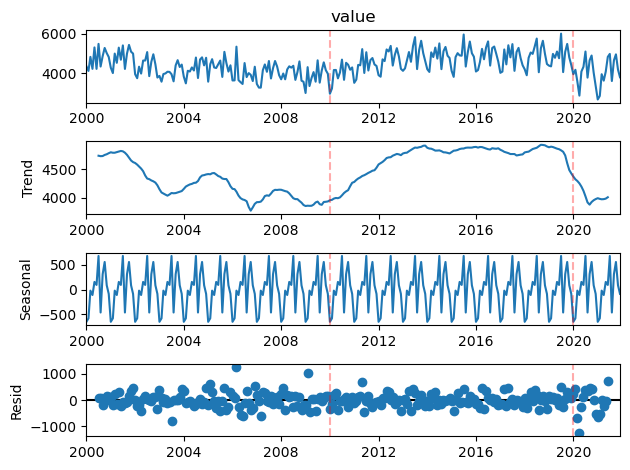

In [6]:
total_series = df[df.accident_type == "total"].groupby("date").value.sum()

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(total_series, model="additive", period=12)
decomposition.plot()

for ax in plt.gcf().axes:
    ax.axvline(
        pd.to_datetime("2020-01-01"),
        color="red",
        linestyle="--",
        label="start of pandemic",
        alpha=0.33,
    )
    ax.axvline(
        pd.to_datetime("2010-01-01"),
        color="red",
        linestyle="--",
        label="increase of traffic accidents",
        alpha=0.33,
    )